DATA DOWNLOAD: https://www.cs.toronto.edu/~kriz/cifar.html  
This is a CNN model for CIFAR10 and we can find the performance is far better than simple neural network.  
______

# 1. Load data

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path. It might take a few minutes to download. Just wait.

In [41]:
import cifar10
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [43]:
class_names = cifar10.load_class_names()
print(class_names)

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot arrays called labels.

In [44]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [45]:
print(images_train.shape)
print(cls_train.shape)
print(labels_train.shape)

(50000, 32, 32, 3)
(50000,)
(50000, 10)


Load the test-set.

In [46]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [47]:
print(images_test.shape)
print(cls_test.shape)
print(labels_test.shape)

(10000, 32, 32, 3)
(10000,)
(10000, 10)


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [49]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


Data Dimensions

In [51]:
from cifar10 import img_size, num_channels, num_classes
print(img_size)
print(num_channels) # RGB
print(num_classes)

32
3
10


Plot a few images to see.

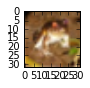

frog


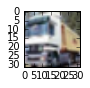

truck


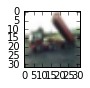

truck


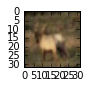

deer


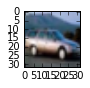

automobile


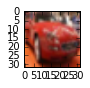

automobile


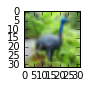

bird


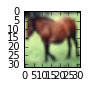

horse


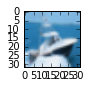

ship


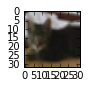

cat


In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    img = images_train[i]
    label = labels_train[i]
    
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()
    cls = np.argmax(label)
    cls_name = class_names[cls]
    print(cls_name)

# 2. Train a two-layer neural network on CIFAR-10

### Help functions

In [53]:
import tensorflow as tf

def weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, padding='SAME'):
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding = padding)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1,2,2,1], strides = [1,2,2,1], padding='VALID')

### Build the compuation graph.

In [56]:
# 1. Create the model (build the compuation graph)
## Hyperparameters
batch_size = 64
W_input = 32 # width of the image
H_input = 32 # height of the image
C_input = 3  # channel of the image
W1 = 5; H1 = 5; C1 = 32 # conv-1
W2 = 5; H2 = 5; C2 = 64 # conv-2
C3 = 512
n_classes = 10
learning_rate = 1e-3

## Model input
x = tf.placeholder(tf.float32, [None, W_input, H_input, C_input])

# 1st conv layer
W_conv1 = weight([W1,H1,C_input,C1])
b_conv1 = bias([C1])
h_conv1 = conv2d(x, W_conv1) + b_conv1
h_conv1 = tf.nn.relu(h_conv1)
h_pool1 = max_pool_2x2(h_conv1) # 16*16*C1

# 2nd conv layer
W_conv2 = weight([W2,H2,C1,C2])
b_conv2 = bias([C2])
h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
h_conv2 = tf.nn.relu(h_conv2)
h_pool2 = max_pool_2x2(h_conv2) # feature size: 8x8xC2

# densely connected layer with 1024 neurons
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*C2])
W_fc = weight([8*8*C2,C3])
b_fc = bias([C3])
h_fc = tf.matmul(h_pool2_flat, W_fc) + b_fc
h_fc = tf.nn.relu(h_fc)

p_keep = tf.placeholder(tf.float32)
h_fc = tf.nn.dropout(h_fc, p_keep)

# output layer
W_output = weight([C3,10])
b_output = bias([10])
y_pred = tf.matmul(h_fc, W_output) + b_output


## Define loss and optimizer
y_gt = tf.placeholder(tf.float32, [None, n_classes])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_gt))

## Train (update model parameters)
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = optimizer.minimize(loss)

## Compute Accuracy
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_gt, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [57]:
def random_batch(images_train, labels_train, batch_size):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Train

In [58]:
## Initialize
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

max_iter = 10000

images_train = images_train.reshape([50000, 32, 32, 3])
images_test = images_test.reshape([10000, 32, 32, 3])


for iter in range(max_iter):
    batch_x, batch_y = random_batch(images_train, labels_train, batch_size)
    sess.run(train_step, feed_dict = {x: batch_x, y_gt: batch_y, p_keep:0.5})
    if iter % 100 == 0:
        train_loss = sess.run(loss, feed_dict = {x: batch_x, y_gt: batch_y, p_keep:1.0})
        train_accuracy = sess.run(accuracy, feed_dict = {x: batch_x, y_gt: batch_y, p_keep:1.0})

        test_accuracy = 0
        for k in range(5):
            test_x = images_test[k*2000:(k+1)*2000,:]
            test_y = labels_test[k*2000:(k+1)*2000,:]
            test_accuracy += sess.run(accuracy, {x: test_x, y_gt: test_y, p_keep:1.0})
        test_accuracy /= 5

        print("iter step %d, loss %f, training accuracy %f, test accuracy %f" %
              (iter, train_loss, train_accuracy, test_accuracy))

iter step 0, loss 6.276674, training accuracy 0.218750, test accuracy 0.110000
iter step 100, loss 1.715987, training accuracy 0.437500, test accuracy 0.360100
iter step 200, loss 1.639674, training accuracy 0.312500, test accuracy 0.427200
iter step 300, loss 1.541205, training accuracy 0.406250, test accuracy 0.478000
iter step 400, loss 1.180428, training accuracy 0.671875, test accuracy 0.502800
iter step 500, loss 1.241315, training accuracy 0.546875, test accuracy 0.503100
iter step 600, loss 1.083446, training accuracy 0.625000, test accuracy 0.513600
iter step 700, loss 1.135533, training accuracy 0.640625, test accuracy 0.549100
iter step 800, loss 1.200736, training accuracy 0.593750, test accuracy 0.541700
iter step 900, loss 1.223293, training accuracy 0.609375, test accuracy 0.553800
iter step 1000, loss 1.215877, training accuracy 0.625000, test accuracy 0.559600
iter step 1100, loss 0.868205, training accuracy 0.687500, test accuracy 0.574700
iter step 1200, loss 0.94946

### Use some examples to test your model 

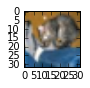

Ground Truth: cat
Model prediction: cat


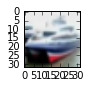

Ground Truth: ship
Model prediction: automobile


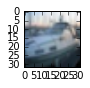

Ground Truth: ship
Model prediction: airplane


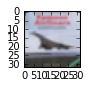

Ground Truth: airplane
Model prediction: airplane


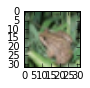

Ground Truth: frog
Model prediction: frog


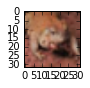

Ground Truth: frog
Model prediction: frog


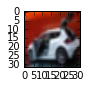

Ground Truth: automobile
Model prediction: automobile


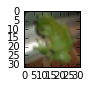

Ground Truth: frog
Model prediction: frog


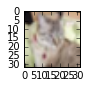

Ground Truth: cat
Model prediction: cat


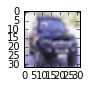

Ground Truth: automobile
Model prediction: automobile


In [62]:
images_train = images_train.reshape([50000, 32, 32, 3])
images_test = images_test.reshape([10000, 32, 32, 3])
for i in range(10):
    img = images_test[i]
    label = labels_test[i]
    
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()
    cls = np.argmax(label)
    cls_name = class_names[cls]
    print("Ground Truth: %s" % cls_name)
    
    pred_label = sess.run(y_pred, feed_dict = {x: img.reshape([1, 32, 32, 3]), p_keep:1.0})
    pred_cls = np.argmax(pred_label)
    pred_cls_name = class_names[pred_cls]
    print("Model prediction: %s" % pred_cls_name)